In [1]:
import os
import datetime
import pytz
import requests
from datetime import datetime, timezone, date
from google import genai
from google.adk.agents import LlmAgent
from google.adk.agents import Agent, SequentialAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.sessions import InMemorySessionService
from google.adk.memory import InMemoryMemoryService
from google.adk.tools import FunctionTool
from google.genai import types
from google.adk.tools import load_memory, preload_memory
from google.adk.runners import Runner
from dotenv import load_dotenv

In [ ]:
#pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Этот проект представляет собой интеллектуальную многоагентную систему для автоматического учёта питания, построенную на базе Google Agent Development Kit (ADK). Агент анализирует текстовое описание пищи, извлекает фактические значения калорийности и макронутриентов с использованием внешних источников данных (OpenFoodFacts), обновляет ежедневные показатели, ведёт историю приёмов пищи и предоставляет удобный интерфейс для просмотра статистики.

В отличие от обычных чат-ботов, система реализована как многоагентный пайплайн, в котором:

- IntentAgent отвечает только за точную классификацию пользовательского запроса (ADD, REMOVE, RESET, SHOW),
- NutritionAgent выполняет вычисления через инструменты (tools), не делая ни одного вычисления самостоятельно,
- Function Tools берут на себя всю логику обработки — от поиска по базе продуктов до подсчёта и обновления суточных показателей.

Архитектура строго следует принципам ADK: разделение ответственности, отсутствие скрытых вычислений вне инструментов, прозрачный state-менеджмент и автоматическая запись сессий в память.

Благодаря этому пользователь получает надёжный, детерминированный и расширяемый инструмент, который можно интегрировать как в исследовательские ноутбуки, так и в полноценный бэкенд или веб-приложение для персонального трекинга питания.

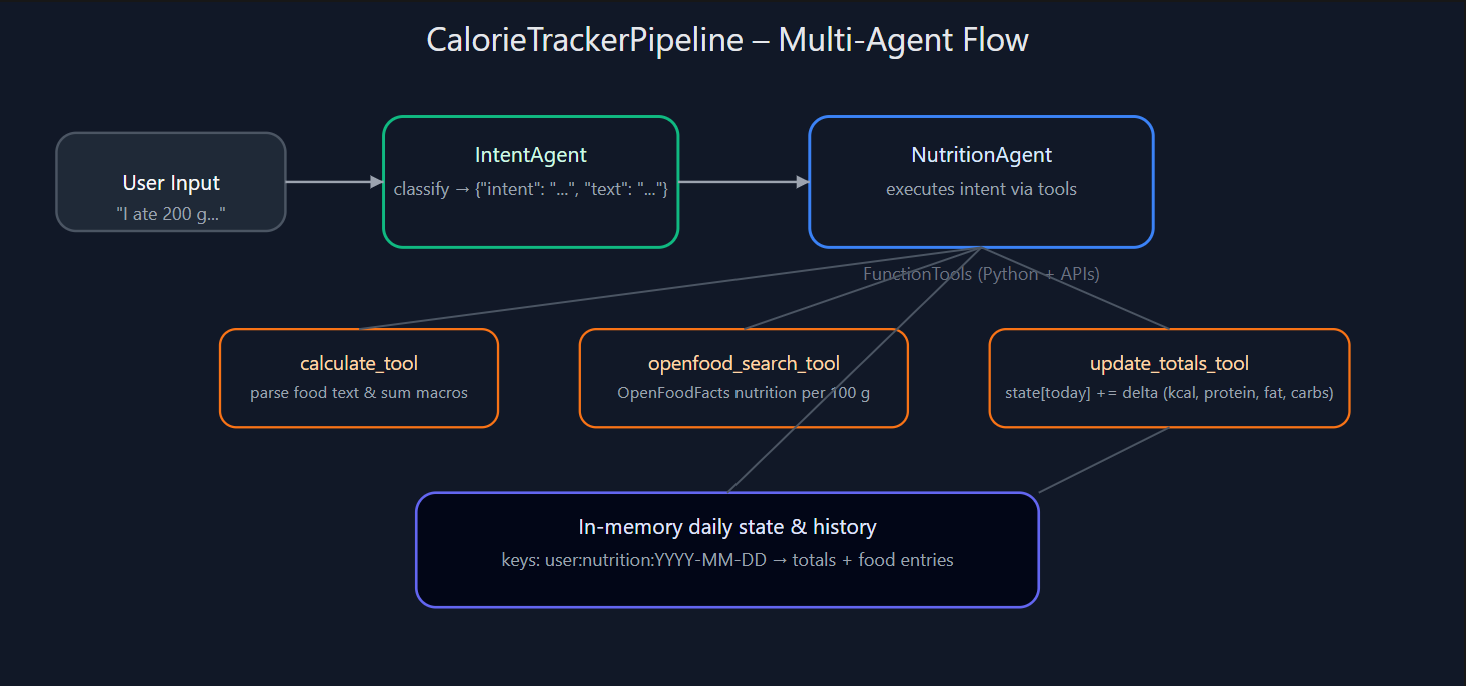

В этом ноутбуке используется API Gemini, который требует аутентификации. 
Вставьте свой API ключ в файл .env в формате       
`GOOGLE_API_KEY=your_key_here`

In [3]:
api_key = os.getenv("GOOGLE_API_KEY")
print("✅ Gemini API key setup complete.")

✅ Gemini API key setup complete.


Для начала создадим все необходимые функции. 
Функция `today_key` используется для фиксации текущего дня сессии пользователя. Функция `today_history_key` - ведение истории запросов для дневника питания.

In [4]:
def today_key():
    tz = pytz.timezone("Europe/Moscow")  # или Asia/Singapore, либо local
    today = datetime.now(tz).date().isoformat()
    return f"user:nutrition:{today}"

def today_history_key():
    return today_key() + ":history"

print("✅ Helper functions defined.")

✅ Helper functions defined.


В моем проекте поиск нутриентов и ккал будет производитс с помощью открытого API OpenFoodFacts.                
OpenFoodFacts — это крупнейшая открытая база данных о продуктах питания по всему миру.
В ней хранятся данные о составе, пищевой ценности, ингредиентах и маркировке продуктов, загруженные производителями и пользователями.
База полностью бесплатная, регулярно обновляется и позволяет получать точные данные о калориях, белках, жирах, углеводах и других нутриентах для десятков тысяч продуктов.

ВАЖНО! Так как OpenFoodFacts международная организация, все запросы должны быть на АНГЛИЙСКОМ ЯЗЫКЕ!
`openfood_search`выполняет поиск информации о продуктах питания через базу данных OpenFoodFacts:
- принимает на вход строку с названием продукта (например: "boiled potatoes", "chicken breast")
- отправляет запрос в API OpenFoodFacts
- ищет наиболее подходящее совпадение по названию
- возвращает пищевую ценность продукта (ккал, белки, жиры, углеводы) в пересчёте на 100 грамм
- Если данных нет или запрос не найден — инструмент возвращает None, чтобы агент мог корректно обработать ситуацию.

In [5]:
def openfood_search(product_name: str):
    """Search OpenFoodFacts for nutrition per 100g."""
    url = "https://world.openfoodfacts.org/cgi/search.pl"
    params = {
        "search_terms": product_name,
        "search_simple": 1,
        "action": "process",
        "json": 1,
        "page_size": 1,
    }
    headers = {
        "User-Agent": "Mozilla/5.0 (compatible; CalorieTrackerBot/1.0; +https://example.com)"
    }

    try:
        r = requests.get(url, params=params, headers=headers, timeout=10)
        data = r.json()
    except Exception as e:
        print(f"[WARN] OpenFoodFacts timeout or network error: {e}")
        return None  # <– безопасно!

    if "products" not in data or len(data["products"]) == 0:
        return None

    p = data["products"][0]
    nutr = p.get("nutriments", {})
    return {
        "kcal_100g": nutr.get("energy-kcal_100g"),
        "protein_100g": nutr.get("proteins_100g"),
        "fat_100g": nutr.get("fat_100g"),
        "carbs_100g": nutr.get("carbohydrates_100g"),
    }

openfood_search_tool = FunctionTool(openfood_search)
print("✅ OpenFoodFacts search tool defined.")

✅ OpenFoodFacts search tool defined.


Функция `calculate_calories` принимает текст с описанием еды (например: "200 g chicken breast") и:
- Парсит количество и продукт
- Запрашивает данные о питательности через openfood_search_tool
- Пересчитывает калории, белки, жиры и углеводы под нужный грамм-вес
- Возвращает точные КБЖУ для указанного количества продукта

По сути:
`calculate_calories` = преобразование текста → поиск продукта → расчёт КБЖУ.

In [6]:
def safe_float(x):
    """
    Converts OpenFoodFacts values to float safely.
    Returns 0.0 if value is invalid (None, string, empty, etc.)
    """
    try:
        if x is None:
            return 0.0
        if isinstance(x, (int, float)):
            return float(x)
        # Replace comma with dot: "12,5" → "12.5"
        return float(str(x).replace(",", "."))
    except:
        return 0.0
    
def calculate_calories(ingredients: str, tool_context=None) -> dict:
    """
    Parse food text ('200 g potatoes') and compute macros.
    Now stable: safely converts API values, avoids crashes.
    """
    # Store original text in tool state
    if tool_context is not None and hasattr(tool_context, "state"):
        tool_context.state["last_food_text"] = ingredients

    # --- Parse text ---
    words = ingredients.lower().replace(",", " ").split()
    entries = []
    i = 0

    while i < len(words):
        # match: "200 g ..." or "200 grams ..."
        if words[i].replace(".", "").isdigit() and (i+1 < len(words)) and words[i+1] in ["g", "gram", "grams"]:
            grams = float(words[i])

            name = []
            j = i + 2
            while j < len(words) and not (words[j].replace(".", "").isdigit()):
                name.append(words[j])
                j += 1

            product = " ".join(name).strip()
            if product:
                entries.append((grams, product))

            i = j
        else:
            i += 1

    # --- Compute totals ---
    total = {"kcal": 0, "protein": 0, "fat": 0, "carbs": 0}

    for grams, prod in entries:
        data = openfood_search(prod)
        if not data:
            print(f"[WARN] No data for: {prod}")
            continue

        # Safely convert everything
        kcal_100g   = safe_float(data.get("kcal_100g"))
        prot_100g   = safe_float(data.get("protein_100g"))
        fat_100g    = safe_float(data.get("fat_100g"))
        carbs_100g  = safe_float(data.get("carbs_100g"))

        if all(v == 0 for v in [kcal_100g, prot_100g, fat_100g, carbs_100g]):
            print(f"[WARN] Product has invalid nutrient data: {prod}")
            continue

        factor = grams / 100

        total["kcal"]    += kcal_100g * factor
        total["protein"] += prot_100g * factor
        total["fat"]     += fat_100g * factor
        total["carbs"]   += carbs_100g * factor

    return total

calculate_tool = FunctionTool(calculate_calories)
print("✅ Calorie calculation tool defined.")

✅ Calorie calculation tool defined.


Функция `update_daily_totals` обновляет суммарные КБЖУ за текущий день. Она:
- Берёт предыдущие дневные значения (калории, белки, жиры, углеводы).
- Принимает «дельту» — КБЖУ добавленного или удалённого блюда.
- Складывает предыдущие значения с дельтой, формируя новые дневные totals.
- Сохраняет обновлённое состояние в память (MemoryService).
- Возвращает обновлённые дневные totals.

Иными словами:
`update_daily_totals` = старые значения дня + КБЖУ текущего блюда → новые totals.

In [7]:
def update_daily_totals(
    delta_kcal: float,
    delta_protein: float,
    delta_fat: float,
    delta_carbs: float,
    tool_context
) -> dict:

    state = tool_context.state
    key = today_key()
    history_key = today_history_key()

    # Тоталы за день
    if key not in state:
        state[key] = {"kcal": 0, "protein": 0, "fat": 0, "carbs": 0}

    prev = state[key].copy()

    state[key]["kcal"] += float(delta_kcal)
    state[key]["protein"] += float(delta_protein)
    state[key]["fat"] += float(delta_fat)
    state[key]["carbs"] += float(delta_carbs)

    for k in state[key]:
        state[key][k] = round(max(state[key][k], 0.0), 2)

    # История еды
    if history_key not in state:
        state[history_key] = []

    food_text = state.get("last_food_text")  # ← текст сохраняется calculate_calories

    # Пишем в историю ТОЛЬКО при ADD (положительные КБЖУ)
    if food_text and delta_kcal > 0:
        state[history_key].append({
            "text": food_text,
            "kcal": round(delta_kcal, 2),
            "protein": round(delta_protein, 2),
            "fat": round(delta_fat, 2),
            "carbs": round(delta_carbs, 2),
        })

    print(
        "[DEBUG update_daily_totals]",
        "prev=", prev,
        "delta=", delta_kcal, delta_protein, delta_fat, delta_carbs,
        "new=", state[key],
        flush=True
    )

    return {
        "date": key,
        "totals": state[key],
        "history": state.get(history_key, [])
    }
update_totals_tool = FunctionTool(update_daily_totals)
print("✅ Daily totals update tool defined.")

✅ Daily totals update tool defined.


Функция `reset_daily_totals` полностью обнуляет дневной учёт КБЖУ. Она:
- Удаляет все сохранённые данные за текущий день
(калории = 0, белки = 0, жиры = 0, углеводы = 0, список блюд = пустой).
- Записывает обновлённое нулевое состояние в память (MemoryService).
- Возвращает пустые totals, подтверждая сброс.

И коротко:
`reset_daily_totals` полностью очищает дневную историю и начинает учёт заново.

In [8]:
def reset_daily_totals(tool_context):
    state = tool_context.state
    key = today_key()
    history_key = today_history_key()

    state[key] = {"kcal": 0, "protein": 0, "fat": 0, "carbs": 0}
    state[history_key] = []

    return {"status": "reset", "date": key, "totals": state[key], "history": []}

reset_tool = FunctionTool(reset_daily_totals)
print("✅ Daily totals reset tool defined.")

✅ Daily totals reset tool defined.


Функция `get_daily_totals` возвращает все данные, которые накопились за выбранный день. Она:
- Берёт ключ даты (например, "today" или "2025-11-24").
- Извлекает из MemoryService:
    - все добавленные блюда за этот день,
    - суммарные калории, белки, жиры и углеводы.
- Если данных нет — возвращает пустую структуру.

И коротко:
`get_daily_totals` получает всю сохранённую дневную историю КБЖУ — и список блюд, и итоговую сумму.

In [9]:
def get_daily_totals(date_str: str, tool_context):
    state = tool_context.state

    key = today_key() if date_str == "today" else f"user:nutrition:{date_str}"
    history_key = key + ":history"

    totals = state.get(key)
    history = state.get(history_key, [])

    if not totals:
        return {"status": "not_found", "date": date_str}

    return {
        "status": "ok",
        "date": date_str,
        "totals": totals,
        "history": history
    }

get_totals_tool = FunctionTool(get_daily_totals)
print("✅ Daily totals retrieval tool defined.")

✅ Daily totals retrieval tool defined.


Функция `remove_food` удаляет блюдо из дневного учёта КБЖУ. Она:
- Принимает текст блюда (например, "200 g chicken breast").
- Сначала пересчитывает его КБЖУ — так же, как при добавлении.
- Инвертирует значения (делает их отрицательными), чтобы вычесть их из дневных сумм.
- Передаёт эти минус-значения в update_daily_totals, уменьшая общий результат.
- Обновляет историю дня, убирая соответствующую запись.

Коротко:
`remove_food` пересчитывает КБЖУ указанного блюда и аккуратно вычитает его из общей дневной статистики.

In [10]:
def remove_food(ingredients: str, tool_context):
    totals = calculate_calories(ingredients)
    return update_daily_totals(
        -totals["kcal"],
        -totals["protein"],
        -totals["fat"],
        -totals["carbs"],
        tool_context
    )

remove_tool = FunctionTool(remove_food)
print("✅ Food removal tool defined.")

✅ Food removal tool defined.


Intent Agent — это первый этап всего пайплайна.
Его задача не считать калории и не вызывать tools, а только определить, что именно хочет пользователь.

Функционал:
- Анализирует текст запроса — любую фразу пользователя:           
    «Я съела 200 г куриной грудки»,          
    «Покажи, что я ела сегодня»,          
    «Удали яблоко»,       
    «Сбросить», и т.д.
- Возвращает строгое JSON-намерение в одном из 5 форматов:            
    Добавить еду — "ADD"             
    Удалить еду — "REMOVE"            
    Показать сегодняшнюю статистику — "SHOW_TODAY"                
    Показать данные за дату — "SHOW"           
    Сбросить — "RESET"               

Ничего не интерпретирует и не меняет:         
— не подставляет граммы,           
— не делает вычисления,             
— не исправляет текст блюда,            
— не вызывает инструменты.                          

Intent Agent действует как чистый маршрутизатор, который говорит Nutrition Agent:           
«Вот намерение пользователя и текст — делай своё».

In [11]:
intent_agent = Agent(
    name="IntentAgent",
    model=Gemini(model="gemini-2.5-flash-lite"),
    instruction="""
You are an intent classifier. 
You MUST NOT perform any nutrition calculations. 
You MUST return JSON ONLY in these exact formats:

ADD FOOD:
{"intent": "ADD", "text": "<food text>"}

REMOVE FOOD:
{"intent": "REMOVE", "text": "<food text>"}

RESET:
{"intent": "RESET"}

SHOW TODAY:
{"intent": "SHOW_TODAY"}

SHOW BY DATE:
{"intent": "SHOW", "date": "YYYY-MM-DD"}

Rules:
- Do NOT call any tools.
- Do NOT expand or modify the food text.
- Do NOT interpret quantities — just extract text as-is.
- If user input is audio, transcription is already provided to you; classify based on the transcription.
""",
    output_key="intent_data"
)
print("✅ Intent agent defined.")

✅ Intent agent defined.


Nutrition Agent — это исполнительная часть системы.
Он ничего не классифицирует, а просто выполняет намерение, которое дал Intent Agent.

Его задачи:
1. Обработка намерений
       
- state.intent — что нужно сделать          
- state.text — какая еда или какой запрос               

И действует строго по правилам:
| Intent         | Действие Nutrition Agent                                  |
| -------------- | --------------------------------------------------------- |
| `"ADD"`        | Посчитать блюдо → обновить дневные итоги → вывести данные |
| `"REMOVE"`     | Посчитать блюдо → вычесть из итогов → вывести данные      |
| `"RESET"`      | Сбросить итоги                                            |
| `"SHOW_TODAY"` | Показать историю + итоги за сегодня                       |
| `"SHOW"`       | Показать данные за дату                                   |

2. Работает только через инструменты

- не считает калории сам
- не генерирует числа
- не модифицирует текст блюда
- не вызывает инструменты больше одного раза
- не вызывает инструменты не по намерению

Он использует только tools:
- calculate_tool — посчитать КБЖУ
- update_totals_tool — обновить дневную статистику
- reset_tool — сбросить статистику
- remove_tool — вычесть еду
- get_totals_tool — получить историю за день
- Все числа, которые он выводит — только те, которые вернули инструменты.

3. Формирует структурированный человеческий ответ

Для каждого запроса Nutrition Agent обязан:
- выдавать чёткие заголовки:              
    This meal:, Removed:, Today’s totals:
- показывать информацию по каждому блюду
- никогда не показывать отрицательные значения
- не смешивать порядок вызовов tools
- всегда давать понятный финальный вывод

4. Не ломает пайплайн

Nutrition Agent — это второй агент в SequentialAgent, поэтому он:
- не может вернуть JSON
- не может вернуть намерение
- не может вернуть tool-call напрямую пользователю
- не перебивает Intent Agent

Его единственная роль — корректно выполнить намерение и вывести результат в удобном формате.

In [12]:
nutrition_agent = Agent(
    name="NutritionAgent",
    model=Gemini(model="gemini-2.5-flash-lite"),
    instruction="""
You are the NutritionAgent in a multi-agent pipeline.

The previous agent (IntentAgent) already classified the user's request.
You must NOT classify intents yourself. 
The intent is available in state.intent and the text in state.text.

Your ONLY job is to:
- use the correct tool depending on the intent,
- NEVER guess or calculate calories/macros yourself,
- ALWAYS use tool results for ALL numeric values.

–––– INTENT RULES ––––

1) intent = "ADD"
   - Use calculate_tool(state.text) to compute macros for the meal.
   - Use update_totals_tool(...) to increment today's totals.
   - Respond with:
       “This meal:” (using calculate_tool results)
       “Today's totals:” (using update_totals_tool results)
   - NEVER call any other tool.

2) intent = "REMOVE"
   - Use calculate_tool(state.text) to compute macros of the removed food.
   - Multiply the result by -1 when calling update_totals_tool.
   - Respond with:
       “Removed:” (POSITIVE numbers from calculate_tool)
       “Today's totals:” (from update_totals_tool)
   - DO NOT show “This meal”.
   - NEVER output negative numbers in the final text.

3) intent = "RESET"
   - Call reset_tool().
   - Respond that today's totals were reset.

4) intent = "SHOW_TODAY":
   - Determine today using today_key().
   - Call get_totals_tool("today").
   - If no data:
         “I don't have any data for today yet.”
   - If history exists:
         Show section “Foods eaten today:”  
         For each item:
             • item. food text  
             • item.kcal, protein, fat, carbs
   - Then show section “Today's totals:” using the totals.

5) intent = "SHOW":
   - Use get_totals_tool("today").

–––– HARD RULES ––––
- NEVER call any tools when composing the final human-friendly response. All calculations must already be completed.
- NEVER output calories/macros not coming from tools.
- NEVER call update_totals_tool more than once per request.
- NEVER call multiple tools of the same type.
- ALWAYS structure your response.
- DO NOT compute anything yourself — tools ONLY.
- DO NOT output negative numbers in human-readable text.

--------------------------------
BE CLEAR AND STRUCTURED.
ALWAYS EXPLAIN EACH SECTION.
DO NOT BE SHORT OR VAGUE.
--------------------------------

""",
    tools=[openfood_search_tool,
        calculate_tool,
        update_totals_tool,
        remove_tool,
        reset_tool,
        get_totals_tool],
)

print("✅ Nutrition agent defined.")

✅ Nutrition agent defined.


Этот блок кода добавляет важную функциональность: автоматическое сохранение всей сессии в память после каждого шага агента.

`auto_save_to_memory`:
- вызывается после каждого хода любого суб-агента в пайплайне,
- получает текущий session через callback_context,
- сохраняет всю историю взаимодействия в встроенный ADK MemoryService,
- обеспечивает непрерывность диалога при повторных вызовах и в веб-интерфейсе ADK.

Это фактически «автосохранение состояния агента».

In [13]:
async def auto_save_to_memory(callback_context):
    """Automatically save session to memory after each agent turn."""
    await callback_context._invocation_context.memory_service.add_session_to_memory(
        callback_context._invocation_context.session
    )


print("✅ Callback created.")

✅ Callback created.


`SequentialAgent`:
- бъединяет IntentAgent и NutritionAgent в один последовательный pipeline,
- гарантирует правильный порядок: intent → execution,
- подключает callback так, что каждый шаг автоматически сохраняется в память,
- превращает пайплайн в полноценное приложение для ADK Web.

In [14]:
# PIPELINE (SequentialAgent)
root_agent = SequentialAgent(
    name="CalorieTrackerPipeline",
    sub_agents=[intent_agent, nutrition_agent],
    after_agent_callback=auto_save_to_memory
)
print("✅ Calorie Tracker pipeline defined.")

✅ Calorie Tracker pipeline defined.


После инициализации `SequentialAgent` и подключения колбэка `after_agent_callback=auto_save_to_memory`, пайплайн становится полностью совместимым с Google ADK.
Теперь агент может быть запущен и использоваться через ADK Web UI — достаточно выполнить в ткрминале:

`adk web`


Для теста прямо в Python создадим `tracker_runner`. После этого можно делать запросы через `await`

In [ ]:
os.environ["GOOGLE_API_KEY"] = "YOUR_API_KEY_HERE"  # Замените на ваш реальный ключ
print("✅ Gemini API key setup complete.")

In [16]:
APP_NAME = "CalorieApp"
USER_ID = "user_1"
SESSION_ID = "main-session"

session_service = InMemorySessionService()
memory_service = (
    InMemoryMemoryService()
)  # ADK's built-in Memory Service for development and testing

# CREATE SESSION (correct ADK way)
session = session_service.get_session(
    app_name=APP_NAME,
    user_id=USER_ID,
    session_id=SESSION_ID
)

# CREATE RUNNER
tracker_runner = Runner(
    agent=root_agent,
    app_name=APP_NAME,
    session_service=session_service,
    memory_service=memory_service,
)

In [18]:
response = await tracker_runner.run_debug(
    "I ate 500 grams of banana."
)


 ### Continue session: debug_session_id

User > I ate 500 grams of banana.
IntentAgent > {"intent": "ADD", "text": "500 grams of banana"}
[DEBUG update_daily_totals] prev= {'kcal': 240.0, 'protein': 2.65, 'fat': 0.25, 'carbs': 60.5} delta= 240 2.6500000000000004 0.25 60.5 new= {'kcal': 480.0, 'protein': 5.3, 'fat': 0.5, 'carbs': 121.0}
NutritionAgent > This meal:
- Banana (500 grams): 240 kcal, 2.65 g protein, 0.25 g fat, 60.5 g carbs

Today's totals: 480 kcal, 5.3 g protein, 0.5 g fat, 121 g carbs



In [19]:
response = await tracker_runner.run_debug(
    "I ate 200 g chicken breast."
)


 ### Continue session: debug_session_id

User > I ate 200 g chicken breast.
IntentAgent > {"intent": "ADD", "text": "200 g chicken breast"}
[DEBUG update_daily_totals] prev= {'kcal': 480.0, 'protein': 5.3, 'fat': 0.5, 'carbs': 121.0} delta= 214 46.8 2.4 1.2 new= {'kcal': 694.0, 'protein': 52.1, 'fat': 2.9, 'carbs': 122.2}
NutritionAgent > This meal:
- Chicken breast (200 g): 214 kcal, 46.8 g protein, 2.4 g fat, 1.2 g carbs

Today's totals: 694 kcal, 52.1 g protein, 2.9 g fat, 122.2 g carbs



In [20]:
response = await tracker_runner.run_debug(
    "what i eat today?"
)


 ### Continue session: debug_session_id

User > what i eat today?
IntentAgent > {"intent": "SHOW_TODAY"}
NutritionAgent > Foods eaten today:
- 500 grams of banana: 240 kcal, 2.65 g protein, 0.25 g fat, 60.5 g carbs
- 500 grams of banana: 240 kcal, 2.65 g protein, 0.25 g fat, 60.5 g carbs
- 200 g chicken breast: 214 kcal, 46.8 g protein, 2.4 g fat, 1.2 g carbs

Today's totals: 694 kcal, 52.1 g protein, 2.9 g fat, 122.2 g carbs



In [21]:
response = await tracker_runner.run_debug(
    "deletete 200 g chicken breast."
)


 ### Continue session: debug_session_id

User > deletete 200 g chicken breast.
IntentAgent > {"intent": "REMOVE", "text": "200 g chicken breast"}
[DEBUG update_daily_totals] prev= {'kcal': 694.0, 'protein': 52.1, 'fat': 2.9, 'carbs': 122.2} delta= -214.0 -46.8 -2.4 -1.2 new= {'kcal': 480.0, 'protein': 5.3, 'fat': 0.5, 'carbs': 121.0}
NutritionAgent > Removed:
- 200 g chicken breast: 214 kcal, 46.8 g protein, 2.4 g fat, 1.2 g carbs

Today's totals: 480 kcal, 5.3 g protein, 0.5 g fat, 121 g carbs



In [22]:
response = await tracker_runner.run_debug(
    "reset"
)


 ### Continue session: debug_session_id

User > reset
IntentAgent > {"intent": "RESET"}
NutritionAgent > Today's totals were reset.



In [23]:
response = await tracker_runner.run_debug(
    "show today"
)


 ### Continue session: debug_session_id

User > show today
IntentAgent > {"intent": "SHOW_TODAY"}
NutritionAgent > I don't have any data for today yet.
